## Description of notebook

In this notebook, an usupervised bias detection tool is applied on synthetic data of the CUB process from 2014. The synthetic dataset (n=20.000) reflects group level characteristics of students that were registered to receive a college grant on 01-02-2014 by the Dutch Executive Education Agency (DUO). A clustering algorithm is applied to identify groups of similar students that are treated differently.

## Table of contents

0. Import libraries and data
1. Data processing
2. Clustering
3. Analysis of cluster with most bias
4. Analysis of all identifief clusters

## 0. Import libraries and data

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unsupervised_bias_detection.clustering import BiasAwareHierarchicalKModes
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('../data/Table1_SD_20k.csv', sep=",", index_col='Unnamed: 0')
df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal
0,MBO 3-4,19-20,5-10km,5,Not available,NaN
1,WO,25-50,50-500km,4,Not available,NaN
2,MBO 3-4,19-20,50-500km,5,Not available,NaN
3,WO,21-22,20-50km,6,Not available,NaN
4,WO,19-20,50-500km,2,Not available,NaN


In [3]:
df.shape

(20000, 6)

## 1. Data processing

In [4]:
# mapping high risk categories to 0 (more bias) and low risk categories to 1 (less bias)
# mapping = {6:0, 5:0, 4:1, 3:1, 2:1, 1:1}
mapping = {6:1, 5:1, 4:0, 3:0, 2:0, 1:0}
df['Risk category'] = df['Risk category'].map(mapping)

In [5]:
# # encode columns values to numerical values
# le1, le2, le3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
# df['Education'] = le1.fit_transform(df['Education'])
# df['Age'] = le2.fit_transform(df['Age'])
# df['Distance'] = le3.fit_transform(df['Distance'])

In [6]:
df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal
0,MBO 3-4,19-20,5-10km,1,Not available,NaN
1,WO,25-50,50-500km,0,Not available,NaN
2,MBO 3-4,19-20,50-500km,1,Not available,NaN
3,WO,21-22,20-50km,1,Not available,NaN
4,WO,19-20,50-500km,0,Not available,NaN


## 2. Clustering

In [7]:
features=['Education','Age','Distance']
X = df[features]
y = df['Risk category']
n_iter=20
min_cluster_size=750
hbac = BiasAwareHierarchicalKModes(n_iter=n_iter, min_cluster_size=min_cluster_size).fit(X, y)

In [8]:
# text
print(f'Parameters selected\nNumber of iterations: {n_iter}\nMinimal cluster size: {min_cluster_size}')

Parameters selected
Number of iterations: 20
Minimal cluster size: 750


In [9]:
hbac.n_clusters_

7

In [10]:
# text
print(f'Number of clusters found: {hbac.n_clusters_}')

Number of clusters found: 7


In [11]:
hbac.scores_

array([ 0.0597777 ,  0.0364168 ,  0.02072472,  0.00587807, -0.00048727,
       -0.01217349, -0.02518748])

In [12]:
# cluster with most bias has label 0
df_most_biased_cluster = df[hbac.labels_ == 0]
df_other = df[hbac.labels_ != 0]

In [13]:
# text 
print(f'Cluster with most bias consists of {len(df_most_biased_cluster)} datapoints. The uploaded dataset consists of {df.shape[0]} datapoints.')

Cluster with most bias consists of 939 datapoints. The uploaded dataset consists of 20000 datapoints.


## 3. Analysis of cluster with most bias

In [14]:
# # Invert numerical labels back to original categorical labels
# df['Education'] = le1.inverse_transform(df['Education'])
# df['Age'] = le2.inverse_transform(df['Age'])
# df['Distance'] = le3.inverse_transform(df['Distance'])

In [15]:
def stat_df_cat(df1, df2, features):
    '''
    For categorical data only: Takes dataframe of cluster 
    with highest bias and dataframe of the rest of the 
    datasets and computes differencye in frequency, should 
    return 95% confidence intervals in the future.
    '''   

    # initialize dictionaries
    diff_dict = {}
    # CI_dict_left = {}
    # CI_dict_right = {}

    # range through features
    for feat in features:
        df1_feat = df1[feat].value_counts()
        df2_feat = df2[feat].value_counts()

        # merge dfs on the feat column
        merged_df = pd.merge(df1_feat, df2_feat, on=feat, suffixes=('_df1', '_df2'))
        merged_df['diff'] = merged_df['count_df1']-merged_df['count_df2']
        diff_dict[feat] = merged_df['diff'].to_dict()
        
    # store results in dataframe
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    dataframes = [pd.DataFrame(data, index=['Difference']) for key, data in diff_dict.items()]
    cluster_analysis_df = pd.concat(dataframes, axis=1).T
    # cluster_analysis_df = pd.DataFrame([diff_dict['Education'], chi2_dict, CI_dict_left, CI_dict_right]).T
    # cluster_analysis_df = cluster_analysis_df.sort_values('p-value',ascending=[True])
    # n_rows = cluster_analysis_df.shape[0]

    # # Get errors; (coef - lower bound of conf interval)
    # cluster_analysis_df['errors'] = cluster_analysis_df['difference'] - cluster_analysis_df['[0.025']
    # cluster_analysis_df = cluster_analysis_df.iloc[0:n_rows,]
    # cluster_analysis_df['num'] = [int(i) for i in np.linspace(n_rows-1,0,n_rows)]

    # cluster_analysis_df = cluster_analysis_df.reset_index()
    
    # return(cluster_analysis_df)
    return(cluster_analysis_df)
    # return(diff_dict, chi2_dict, cramer_dict, CI_dict_left, CI_dict_right)

In [16]:
diff_df = stat_df_cat(df_most_biased_cluster,df_other,features=features)
diff_df

,Difference
HBO,-6715
23-24,-2088
25-50,-1794
15-18,-1268
20-50km,-2539
2-5km,-1382
10-20km,-1388
5-10km,-1143
1-2km,-789
1m-1km,-665


Text(0, 0.5, 'Feature')

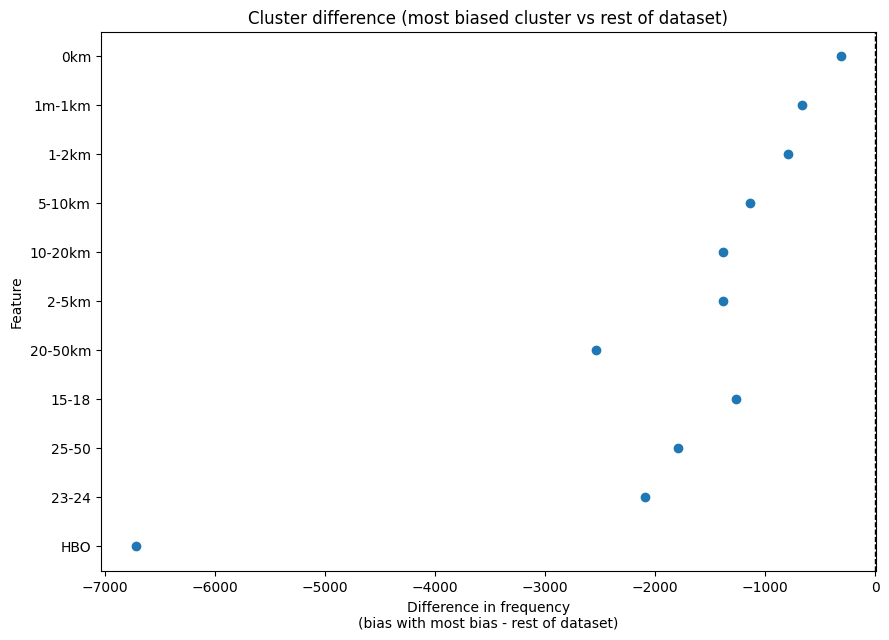

In [17]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(diff_df['Difference'], diff_df.index)

# Line to define zero on the x-axis
ax.axvline(x=0, linestyle='--', color='black', linewidth=1)

# Adding title and labels
plt.title('Cluster difference (most biased cluster vs rest of dataset)')
plt.xlabel('Difference in frequency\n(bias with most bias - rest of dataset)')
plt.ylabel('Feature')

In [32]:
# text 
print('In the most biased cluster there are:')
for feat in diff_df.index:
    diff = diff_df.loc[feat,"Difference"]
    if diff < 0:
        print(f'{abs(diff)} less {feat} than in the rest of the dataset.')
    elif diff > 0:
        print(f'{diff} more {feat} than in the rest of the dataset.')
    elif diff == 0:
        print(f'equal {feat} as in the rest of the dataset.')

In the most biased cluster there are:
6715 less HBO than in the rest of the dataset.
2088 less 23-24 than in the rest of the dataset.
1794 less 25-50 than in the rest of the dataset.
1268 less 15-18 than in the rest of the dataset.
2539 less 20-50km than in the rest of the dataset.
1382 less 2-5km than in the rest of the dataset.
1388 less 10-20km than in the rest of the dataset.
1143 less 5-10km than in the rest of the dataset.
789 less 1-2km than in the rest of the dataset.
665 less 1m-1km than in the rest of the dataset.
315 less 0km than in the rest of the dataset.


## 4. Analysis of all identified clusters

In [33]:
df_cluster1 = df[hbac.labels_ == 1]
df_cluster2 = df[hbac.labels_ == 2]
df_cluster3 = df[hbac.labels_ == 3]
df_cluster4 = df[hbac.labels_ == 4]

df_most_biased_cluster['Cluster'] = '0'
df_cluster1['Cluster'] = '1'
df_cluster2['Cluster'] = '2'
df_cluster3['Cluster'] = '3'
df_cluster4['Cluster'] = '4'

In [34]:
full_df = pd.concat([df_most_biased_cluster, df_cluster1, df_cluster2, df_cluster3, df_cluster4], ignore_index=True)
full_df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal,Cluster
0,HBO,23-24,10-20km,0,Not available,NaN,0
1,HBO,23-24,1-2km,1,Not available,NaN,0
2,HBO,23-24,20-50km,0,Not available,NaN,0
3,HBO,23-24,10-20km,0,Not available,NaN,0
4,HBO,23-24,2-5km,0,Not available,NaN,0


In [35]:
# 47% of the cases has risk label 1
df_most_biased_cluster['Risk category'].mean()

0.46112886048988283

<Axes: ylabel='Cluster'>

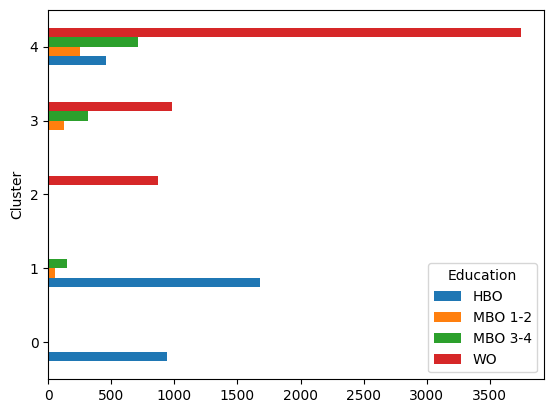

In [21]:
full_df.groupby('Cluster')['Education'].value_counts().unstack().plot.barh()

<Axes: ylabel='Cluster'>

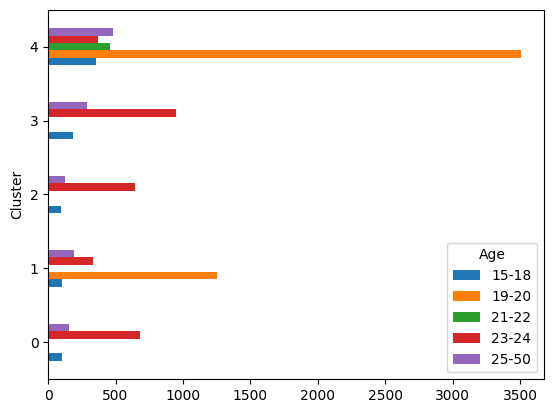

In [22]:
full_df.groupby('Cluster')['Age'].value_counts().unstack().plot.barh()

<Axes: ylabel='Cluster'>

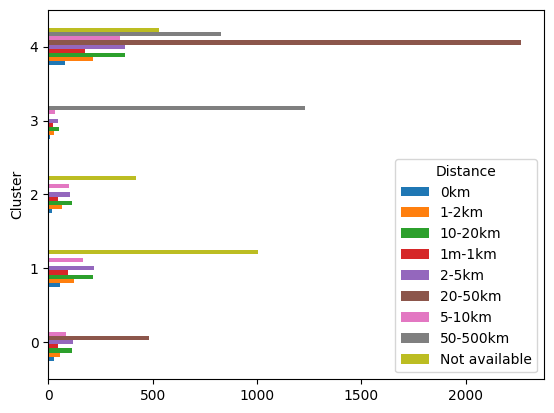

In [23]:
full_df.groupby('Cluster')['Distance'].value_counts().unstack().plot.barh()